In [169]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-attribution/Customerattributiondata.csv


Ref: 
* https://medium.com/@elenek/the-future-of-marketing-attribution-integrating-machine-learning-for-enhanced-insights-2ffa5cfb3f3e
* https://arxiv.org/ftp/arxiv/papers/1804/1804.05327.pdf

In [199]:
import matplotlib.pyplot as plt

# Data Load

The dataset below is private, not to be used further

In [170]:
# loading the data from csv, separator is /t which are not actual tabs but string format, along with parsing the date column.
attribution_data = pd.read_csv('/kaggle/input/customer-attribution/Customerattributiondata.csv', sep='\\t', header = 0, engine='python', parse_dates=['TIMESTAMP_TOUCHPOINT'])
attribution_data.head()

,"""CUSTOMERID",SESSIONID,TIMESTAMP_TOUCHPOINT,MARKETINGCHANNEL,"REVENUE"""
0,"""955200d89b1a4cb0",f1017e8a41ed16a744786a7a74776d2f5c45fde8,2019-12-30 16:40:36,Direct_NON-BRAND,""""
1,"""e4067a9e62ec1936",d832ffe450a04918a5bddd80a9ec9fcb9a5e2815,2019-12-27 17:50:37,Direct_NON-BRAND,""""
2,"""8a48e8219b6c1a29",c1b01222e1c48f1e2dcb8cfa1026a3d72c52a522,2020-01-19 13:41:55,SEO_BRAND,""""
3,"""ef2206d490330882",b0130ba2203b0451a6686d2b1b7216f982a0b8a8,2019-12-15 10:32:40,SEO_BRAND,""""
4,"""b2dde47737c3b716",ac583684bfbe09bd16d73dd40ba584f38638ea1a,2020-01-10 23:52:27,Referral,""""


# Data exploration and cleaning

In [171]:
attribution_data.shape

(13304, 5)

In [172]:
attribution_data.columns

Index(['"CUSTOMERID', 'SESSIONID', 'TIMESTAMP_TOUCHPOINT', 'MARKETINGCHANNEL',
       'REVENUE"'],
      dtype='object')

In [173]:
# renaming columns
attribution_data.rename(columns={'"CUSTOMERID': 'CUSTOMERID', 'REVENUE"': 'REVENUE'}, inplace=True)

> **MarketingChannel column**

In [174]:
# To see the different marketing channels
attribution_data['MARKETINGCHANNEL'].unique()

array(['Direct_NON-BRAND', 'SEO_BRAND', 'Referral', 'SEO_NON-BRAND',
       '""Adwords/"', None, 'Social Media organic_NON-BRAND',
       'Referral_NON-BRAND'], dtype=object)

In [175]:
# string formating for the channels: all lower case, removing extra punctuations, replacing _ and space with -.
attribution_data['MARKETINGCHANNEL'] = attribution_data['MARKETINGCHANNEL'].str.lower()
attribution_data['MARKETINGCHANNEL'] = attribution_data['MARKETINGCHANNEL'].str.replace('""adwords/"','adwords')
attribution_data['MARKETINGCHANNEL'] = attribution_data['MARKETINGCHANNEL'].str.replace('_','-')
attribution_data['MARKETINGCHANNEL'] = attribution_data['MARKETINGCHANNEL'].str.replace(' ','-')

In [176]:
# filling empty values in marketingchannel column to unknown
attribution_data['MARKETINGCHANNEL'].fillna('Unknown',inplace=True)

In [202]:
# droping the Unknown marketingchannel
unique_channels = attribution_data['MARKETINGCHANNEL'].unique()
unique_channels = np.delete(unique_channels, 5)

> **Revenue column**

In [179]:
attribution_data['REVENUE'].unique()

array(['"', None, '1000"'], dtype=object)

In [180]:
# converting string values to int, 1000 or 0 (for None)
attribution_data['REVENUE'] = [1000 if i=='1000"' else 0 for i in attribution_data['REVENUE']]

In [181]:
attribution_data['CUSTOMERID'] = [each[1:] for each in attribution_data['CUSTOMERID']]

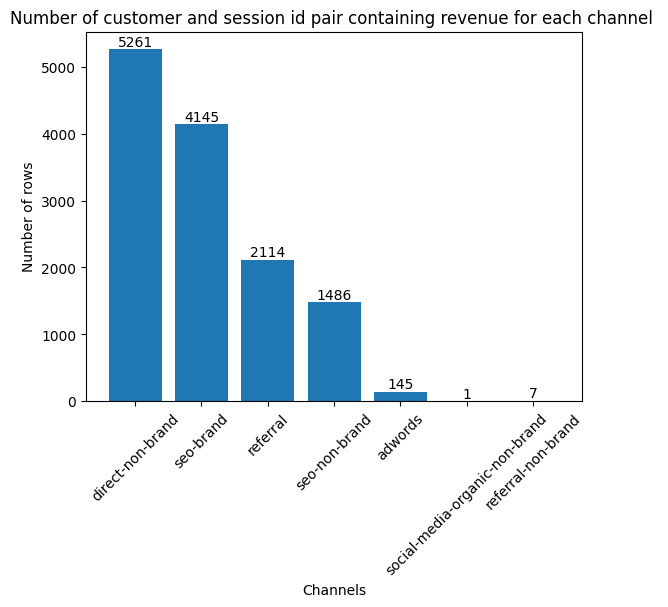

In [207]:
data = [attribution_data[attribution_data['MARKETINGCHANNEL'] == each].shape[0] for each in unique_channels]
plt.bar(unique_channels, data)
plt.xlabel('Channels')
plt.ylabel('Number of rows')
plt.title('Number of customer and session id pair containing revenue for each channel ')
plt.xticks(rotation=45)
# Add y-axis values on top of each bar
for i, v in enumerate(data):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show()


# Data driven solution:

* Accurate results are important, but the heuristic solutions are inflexible and unable to distinguish between the true low and high impact touch-points, resulting in an inaccurate division of credit.

* There are data-driven approaches that address these limitations. Data-driven attribution is a custom solution that is able to capture the intricacies of buyer journeys by modelling how channels, and more importantly how different combinations of channels, interact with buyers to influence a desired sales outcome.

# Calculating the total revenue of unique subsets of marketing channels

In [182]:
data = attribution_data.copy()
# Create a new column that combines multiple sorted marketing channels into a single column
data['marketing_channels_key'] = data.groupby('CUSTOMERID')['MARKETINGCHANNEL'].transform(lambda x: '_'.join(sorted(x)))

# Group the data by the combined marketing channels and calculate the sum of revenue for each group
subset_revenue = data.groupby('marketing_channels_key')['REVENUE'].sum().reset_index()


In [183]:
# removing the duplicate channels in the same string and sorting them
subset_revenue['marketing_channels_key'] = ['_'.join(sorted(list(set(each.split('_'))))) for each in subset_revenue['marketing_channels_key']]

In [184]:
# there are multiple instances of the same marketing_channels_key so grouping and aggregating the revenue
subset_revenue = subset_revenue.groupby('marketing_channels_key')['REVENUE'].sum().reset_index()

In [185]:
subset_revenue.rename(columns={'marketing_channels_key': 'Channels', 'REVENUE': 'Total_revenue'}, inplace=True)

In [187]:
# Dropping the Unknown marketing channel and it's revenue 0
subset_revenue = subset_revenue[1:].reset_index().drop('index', axis=1)

In [188]:
subset_revenue

,Channels,Total_revenue
0,adwords,0
1,adwords_direct-non-brand,2000
2,adwords_direct-non-brand_referral,1000
3,adwords_direct-non-brand_seo-brand,0
4,adwords_direct-non-brand_seo-non-brand,0
5,adwords_referral,0
6,adwords_referral_seo-brand,0
7,adwords_referral_seo-brand_seo-non-brand,0
8,adwords_seo-brand,2000
9,direct-non-brand,379000


In [189]:
# adding custom index for better accessibility
channels_lbl = ['S{}'.format(i) for i in range(1, len(subset_revenue['Channels'])+1)]
subset_revenue['new_index'] = channels_lbl
subset_revenue = subset_revenue.set_index('new_index')
subset_revenue.head()

,Channels,Total_revenue
new_index,,
S1,adwords,0
S2,adwords_direct-non-brand,2000
S3,adwords_direct-non-brand_referral,1000
S4,adwords_direct-non-brand_seo-brand,0
S5,adwords_direct-non-brand_seo-non-brand,0


In [190]:
from itertools import combinations

def subsets(S):
    '''Returns all possible subsets of the given set'''
    s = []
    for i in range(1, len(S)+1):
        s.extend(map(list, combinations(S, i)))
    return list(map('_'.join, s))

In [191]:
d = subset_revenue.shape[0]
B = np.matrix(np.zeros((d, d)))
channels = subset_revenue['Channels']

for i in range(0, d):
    A = channels[i]
    S = subsets(A.split('_'))
    coef = [1 if c in S else 0 for c in channels]
    B[i] = coef

pd.options.display.float_format = '{:,.0f}'.format
pd.DataFrame(data=B, index=channels, columns=channels)

Channels,adwords,adwords_direct-non-brand,adwords_direct-non-brand_referral,adwords_direct-non-brand_seo-brand,adwords_direct-non-brand_seo-non-brand,adwords_referral,adwords_referral_seo-brand,adwords_referral_seo-brand_seo-non-brand,adwords_seo-brand,direct-non-brand,...,direct-non-brand_seo-non-brand,referral,referral-non-brand,referral_seo-brand,referral_seo-brand_seo-non-brand,referral_seo-non-brand,seo-brand,seo-brand_seo-non-brand,seo-brand_social-media-organic-non-brand,seo-non-brand
Channels,,,,,,,,,,,,,,,,,,,,,
adwords,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
adwords_direct-non-brand,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
adwords_direct-non-brand_referral,1,1,1,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
adwords_direct-non-brand_seo-brand,1,1,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
adwords_direct-non-brand_seo-non-brand,1,1,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
adwords_referral,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
adwords_referral_seo-brand,1,0,0,0,0,1,1,0,1,0,...,0,1,0,1,0,0,1,0,0,0
adwords_referral_seo-brand_seo-non-brand,1,0,0,0,0,1,1,1,1,0,...,0,1,0,1,1,1,1,1,0,1
adwords_seo-brand,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


The worth of each possible subset of marketing channel is determined by the characteristic function. In this example, the worth is represented as the sum of revenues of each channel in a subset:

In [192]:
vS = np.dot(B, subset_revenue['Total_revenue'])
vS = np.squeeze(np.asarray(vS))

vSx = ['v({})'.format(lbl) for lbl in channels_lbl]
pd.options.display.float_format = '{:,.2f}'.format
data_characteristicfunc = pd.DataFrame()
data_characteristicfunc['Channels'] = subset_revenue['Channels']
data_characteristicfunc['Worth'] = vS
data_characteristicfunc['vSx'] = vSx
data_characteristicfunc = data_characteristicfunc.set_index('vSx')

In [193]:
data_characteristicfunc

,Channels,Worth
vSx,,
v(S1),adwords,0.00
v(S2),adwords_direct-non-brand,"381,000.00"
v(S3),adwords_direct-non-brand_referral,"566,000.00"
v(S4),adwords_direct-non-brand_seo-brand,"761,000.00"
v(S5),adwords_direct-non-brand_seo-non-brand,"514,000.00"
v(S6),adwords_referral,"156,000.00"
v(S7),adwords_referral_seo-brand,"487,000.00"
v(S8),adwords_referral_seo-brand_seo-non-brand,"626,000.00"
v(S9),adwords_seo-brand,"317,000.00"


# Shapely value calculation

* The Shapley value is a fair way to distribute payoff in a multiplayer game where players can form coalitions to achieve desired outcomes. It calculates a player's average marginal contribution to all possible coalitions, considering that players may join at different times and have varying degrees of influence.
* Here marketing channels are the players of the game, and the various ways in which the channels interact with custmers throughout the buyer journey form the coalitions(marketing channel subsets). 

In [194]:
from collections import defaultdict
from math import factorial

# Calculated the Shapley values - the average value of each channel's marginal contribution
# to the grand coalition, taking into account all possible orderings.

shapley = defaultdict(int)
n = len(unique_channels)
df = pd.DataFrame()
df = data_characteristicfunc['Channels']
df.index = data_characteristicfunc.index

for i in unique_channels:
    for A in data_characteristicfunc['Channels']:
        S = A.split('_')
        if i not in S:
            k = len(S) # Cardinality of set |S|
            Si = S
            Si.append(i)
            Si = '_'.join(sorted(Si))
            # Weight = |S|!(n-|S|-1)!/n!
            if Si in list(data_characteristicfunc['Channels']): 
                weight = (factorial(k) * factorial(n-k-1)) / factorial(n)
            # Marginal contribution = v(S U {i})-v(S)
                contrib = data_characteristicfunc.loc[data_characteristicfunc['Channels'] == Si, 'Worth'][0] - data_characteristicfunc.loc[data_characteristicfunc['Channels'] == A, 'Worth'][0]         
                shapley[i] += weight * contrib
    if i in list(data_characteristicfunc['Channels']): 
        shapley[i] += data_characteristicfunc.loc[data_characteristicfunc['Channels'] == i, 'Worth'][0]/n

In [208]:
# Revenue attribution model:
pd.options.display.float_format = '{:,.3f}'.format
final = pd.DataFrame({
    'Shapley value': list(shapley.values())
}, index=list(shapley.keys()))

In [209]:
final

,Shapley value
direct-non-brand,"117,583.333"
seo-brand,"97,730.952"
referral,"48,973.810"
seo-non-brand,"34,004.762"
adwords,214.286
social-media-organic-non-brand,23.810
referral-non-brand,142.857


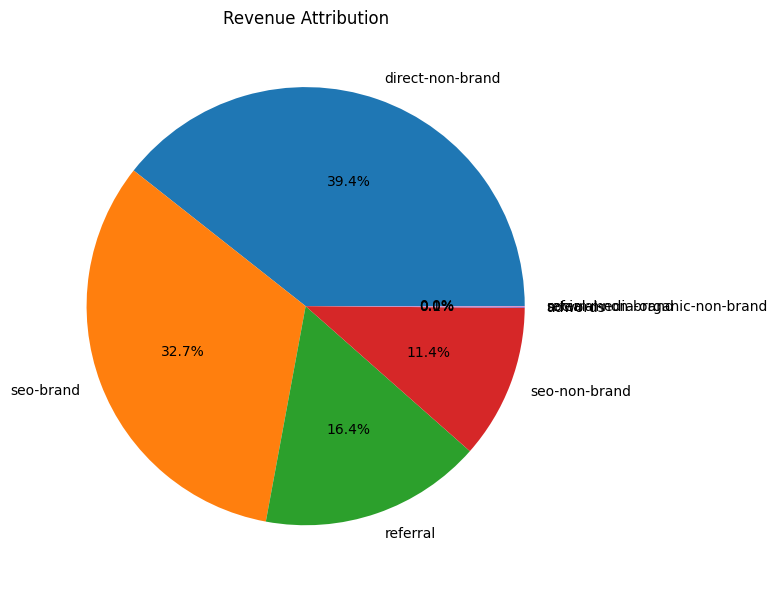

In [216]:
fig, ax = plt.subplots(figsize=(8, 6))
wedges, labels, autopct = ax.pie(final['Shapley value'], labels=final.index, autopct='%1.1f%%')

ax.set_aspect('equal')
plt.title('Revenue Attribution')
plt.tight_layout()

plt.show()